In [2]:
!pip install opencv-python

In [3]:
!pip install torch
!pip install torchvision

In [45]:
import shutil

In [46]:
shutil.rmtree("images_resized")

In [4]:
import zipfile
from pathlib import Path 
import os
import cv2
import xml.etree.ElementTree as ET
import pandas as pd
import torch
from torch import nn
import torchvision
import numpy as np
# torch.utils.data import Dataset, Dataloader
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
import pandas as pd
import skimage.transform
import random
import json
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

In [5]:
api_token = {"username":"fornitroll","key":"XXXXXXXXXXXXXXXXXXXXXXXXXXXXX"}
# create the kaggle folder in the current work directory
!mkdir /root/.kaggle

# create the file kaggle.json in the folder
!touch /root/.kaggle/kaggle.json
# restrict the access to the file in kaggle folder
!chmod 600 /root/.kaggle/kaggle.json
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

In [6]:
!kaggle datasets download -d andrewmvd/road-sign-detection

 96% 209M/218M [00:07<00:00, 20.6MB/s]
100% 218M/218M [00:07<00:00, 31.0MB/s]


In [7]:
zipfile.ZipFile('road-sign-detection.zip').extractall()

In [8]:
img_path = Path('images')
ann_path = Path('annotations')

In [9]:
tree = ET.parse(os.path.join(ann_path,os.listdir(ann_path)[0]))
root = tree.getroot()

In [10]:
os.listdir(ann_path)[0].split('.')[0]

'road104'

In [11]:
root.find("./"+"filename").text

'road104.png'

In [12]:
columns = ["filename", "object/name", "size/width", "size/height", "size/depth", "object/bndbox/xmin", "object/bndbox/ymin", "object/bndbox/xmax", "object/bndbox/ymax"]
col_renames = {i: i.split('/')[-1] for i in columns}

In [13]:
col_renames

{'filename': 'filename',
 'object/bndbox/xmax': 'xmax',
 'object/bndbox/xmin': 'xmin',
 'object/bndbox/ymax': 'ymax',
 'object/bndbox/ymin': 'ymin',
 'object/name': 'name',
 'size/depth': 'depth',
 'size/height': 'height',
 'size/width': 'width'}

In [14]:
#create dataframe with columns: image_path, label, width, height, depth, xmin, ymin, xmax, ymax
df = {}
for i in columns:
  df[i]=[]
for img in os.listdir(img_path):
  i_path = os.path.join(ann_path,img)
  a_path = os.path.join(ann_path,img.split(".")[0]+'.xml')
  tree = ET.parse(a_path)
  root = tree.getroot()
  for i in columns:  
    df[i].append(root.find("./"+i).text)

In [15]:
df = pd.DataFrame(df)
# rename columns
df.rename(columns = col_renames, inplace=True)
# make a fiename as a full path
df.filename = df.filename.apply(lambda x: os.path.join(img_path,x))

In [16]:
def show_img(image_path, data_name):
    image = Image.open(image_path)
    plt.imshow(image, cmap='gray', vmin=0, vmax=255)
    plt.title(data_name)
    plt.show()

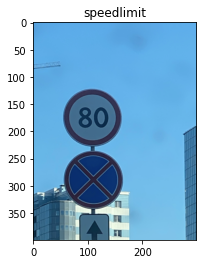

In [17]:
show_img(df.values[1][0], df.name[0])

In [18]:
#Reading an image
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

In [19]:
def create_mask(bb, x):
    """Creates a mask for the bounding box of same shape as image"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int)
    Y[bb[2]:bb[3], bb[0]:bb[1]] = 1.
    return Y

def mask_to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([top_row, bottom_row, left_col, right_col], dtype=np.float32)

def create_bb_array(x):
    """Generates bounding box array from a train_df row"""
    return np.array([x[5],x[7],x[6],x[8]])

In [47]:
def resize_image_bb(read_path,write_path,bb,sz):
    """Resize an image and its bounding box and write image to new path"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (224,224))
    Y_resized = cv2.resize(create_mask(bb, im), (224,224))
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

In [49]:
#Populating Training DF with new paths and bounding boxes
new_paths = []
new_bbs = []
train_path_resized = Path('./images_resized')  # create folder images_resized manualy
for index, row in df.iterrows():
    new_path,new_bb = resize_image_bb(Path(row['filename']), train_path_resized, create_bb_array(row.values),300)
    new_paths.append(new_path)
    new_bbs.append(new_bb)
df['new_path'] = new_paths
df['new_bb'] = new_bbs

In [50]:
im = cv2.imread(str(df.values[1][9]))
bb = df.values[1][10]
print(im.shape)
print(bb)

(224, 224, 3)
[ 40. 123.  68. 127.]


In [51]:
Y = create_mask(bb, im)
print(Y.shape)
mask_to_bb(Y)

(224, 224)


array([ 40., 122.,  68., 126.], dtype=float32)

In [52]:
df.values[44][10]

array([ 69.,  87., 114., 127.], dtype=float32)

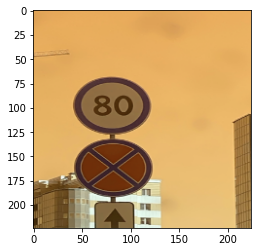

In [53]:
plt.imshow(im)

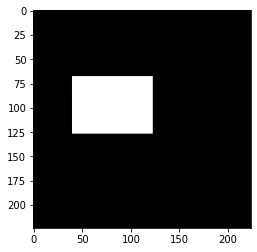

In [54]:
plt.imshow(Y, cmap='gray')

In [55]:
bb

array([ 40., 123.,  68., 127.], dtype=float32)

In [56]:
df.values[1]

array(['images/road484.png', 'speedlimit', '300', '400', '3', '54', '122',
       '165', '228', 'images_resized/road484.png',
       array([ 40., 123.,  68., 127.], dtype=float32)], dtype=object)

In [57]:
# Data augmentation

In [58]:
# modified from fast.ai
def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

# random crop to the original size
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)

def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M,(c,r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

def random_cropXY(x, Y, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    xx = crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)
    YY = crop(Y, start_r, start_c, r-2*r_pix, c-2*c_pix)
    return xx, YY

def transformsXY(path, bb, transforms):
    
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    Y = create_mask(bb, x)
    if transforms:
        rdeg = (np.random.random()-.50)*20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, mask_to_bb(Y)

In [59]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[0], bb[3]), bb[3]-bb[2], bb[0]-bb[1], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

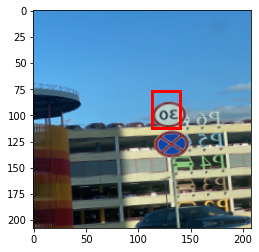

In [60]:
# after transformation
im, bb = transformsXY(df.values[95][9],df.values[95][10],True)
show_corner_bb(im, bb)

In [109]:
df.name.unique()

array(['speedlimit', 'crosswalk', 'stop', 'trafficlight'], dtype=object)

In [110]:
class_lbl = {'speedlimit':0, 'crosswalk':1, 'stop':2, 'trafficlight':3}
df.name = df.name.apply(lambda x: class_lbl[x])

In [111]:
df.name.unique()

array([0, 1, 2, 3])

In [112]:
# split the set
X_train, X_test = train_test_split(df, test_size=0.2, random_state=42)

In [113]:
def normalize(im):
#Normalizes images with Imagenet stats
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [135]:
# Create your own dataset object

class Dataset(Dataset):

    # Constructor
    def __init__(self, data, transform=True):

        self.x= data.new_path
        self.y = data.name
        self.bb = data.new_bb
        self.transform = transform

    
    # Get the length
    def __len__(self):
        return self.y.shape[0]
    
    # Getter
    def __getitem__(self, idx):
        
        # Image file path
        img_name=self.x.iloc[idx]
        # The class label for the image and bb coordinates
        y = self.y.iloc[idx]
        bb = self.bb.iloc[idx]
        # Open image file
        image,bb = transformsXY(img_name, bb, self.transform)         
        image = normalize(image)
        image = np.rollaxis(image, 2)
        image=torch.FloatTensor(image.astype(np.float32))
        return image, y, bb

In [136]:
train_dataset = Dataset(X_train, transform=True)
test_dataset = Dataset(X_test, transform=False)

In [84]:
moved = np.moveaxis(train_dataset[9][0], -1,0)
moved.shape

(3, 208, 208)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


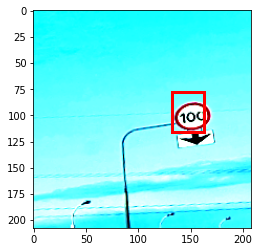

In [160]:
im_numb = 22
im, y, bb = train_dataset[im_numb]
show_corner_bb(np.rollaxis(im.numpy(), 0,3), bb)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


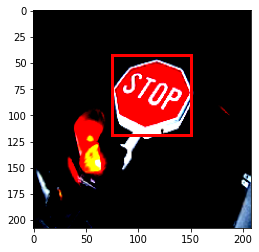

In [161]:
im_numb = 7
im, y, bb = test_dataset[im_numb]
show_corner_bb(np.rollaxis(im.numpy(), 0,3), bb)

In [137]:
batch_size = 64
train_dl = DataLoader(train_dataset, batch_size)
test_dl = DataLoader(test_dataset, batch_size)

In [140]:
# first of all lets try general classification without localization
# resnet18 is used for transfer learning
resnet18 = torchvision.models.resnet18(pretrained=True, progress=None)
resnet18.fc = torch.nn.Linear(in_features=512, out_features=4)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)


def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        resnet18.train() # set model to training phase

        for train_step, (images, labels, _) in enumerate(train_dl):
            images = images.float()
            #labels = labels
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                resnet18.eval() # set model to eval phase

                for val_step, (images, labels, _) in enumerate(test_dl):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                resnet18.train()

                if accuracy >= 0.95:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

In [141]:
train(epochs=3)

Starting training..
Starting epoch 1/3
Evaluating at step 0
Validation Loss: 1.3941, Accuracy: 0.2102
Training Loss: 0.9635
Starting epoch 2/3
Evaluating at step 0
Validation Loss: 0.7331, Accuracy: 0.8409
Training Loss: 0.6567
Starting epoch 3/3
Evaluating at step 0
Validation Loss: 0.5503, Accuracy: 0.8636
Training Loss: 0.4587
Training complete..


In [51]:
# there is two models below. Each of the may be used

In [332]:
batch_size = 32
train_dl = DataLoader(train_dataset, batch_size)
test_dl = DataLoader(test_dataset, batch_size)

class CNN_b(nn.Module):
    def __init__(self):
        super(CNN_b,self).__init__()
        resnet = torchvision.models.resnet18(pretrained=True)
        layers = list(resnet18.children())[:-2]
        self.feature = nn.Sequential(*layers)
        self.adavgpool2d = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512,4))
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512,4))

    def forward(self,x):
        x = self.feature(x)
        x = torch.relu(x)
        x = self.adavgpool2d(x)
        x = torch.flatten(x, 1)

        return self.classifier(x), torch.tensor(self.bb(x)).cuda().float()

In [285]:
batch_size = 32
train_dl = DataLoader(train_dataset, batch_size)
test_dl = DataLoader(test_dataset, batch_size)

class CNN_bb(nn.Module):
    def __init__(self):
        super(CNN_bb, self).__init__()
        resnet = torchvision.models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = torch.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), torch.tensor(self.bb(x)).cuda().float()

In [286]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [326]:
loss1 = nn.CrossEntropyLoss()
loss2 = nn.L1Loss()
def train_epocs(model, optimizer, train_dl, val_dl, epochs=10,C=1000):
    idx = 0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y_class, y_bb in train_dl:
            optimizer.zero_grad()
            batch = len(y_class)
            x = x.cuda().float()
            y_class = y_class.cuda()
            y_bb = torch.tensor(y_bb).cuda().float()
            out_class, out_bb = model(x)
            loss_class = loss1(out_class, y_class)
            loss_bb = loss2(out_bb, y_bb)
            #loss_bb = loss_bb.sum()
            loss = loss_class + loss_bb/C
            
            loss.backward()
            optimizer.step()
            idx += 1
            total += batch
            sum_loss += loss.item()
        train_loss = sum_loss/total
        val_loss, val_acc = val_metrics(model, test_dl, C)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
    return sum_loss/total

In [327]:
def val_metrics(model, valid_dl, C=1000):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for x, y_class, y_bb in valid_dl:
        batch = len(y_class)
        x = x.cuda().float()
        y_class = y_class.cuda()
        y_bb = torch.tensor(y_bb).cuda().float()
        out_class, out_bb = model(x)
        loss_class = loss1(out_class, y_class)
        loss_bb = loss2(out_bb, y_bb)
        #loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        sum_loss += loss.item()
        total += batch
    return sum_loss/total, correct/total

In [333]:
model = CNN_b().cuda()
# model = CNN_bb().cuda()
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.006)

In [334]:
train_epocs(model, optimizer, train_dl, test_dl, epochs=15)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


train_loss 0.052 val_loss 0.071 val_acc 0.716
train_loss 0.035 val_loss 0.078 val_acc 0.761
train_loss 0.029 val_loss 0.029 val_acc 0.767
train_loss 0.027 val_loss 0.028 val_acc 0.801
train_loss 0.027 val_loss 0.026 val_acc 0.801
train_loss 0.026 val_loss 0.033 val_acc 0.778
train_loss 0.025 val_loss 0.025 val_acc 0.790
train_loss 0.024 val_loss 0.029 val_acc 0.784
train_loss 0.024 val_loss 0.024 val_acc 0.818
train_loss 0.024 val_loss 0.025 val_acc 0.795
train_loss 0.026 val_loss 0.035 val_acc 0.790
train_loss 0.026 val_loss 0.029 val_acc 0.807
train_loss 0.023 val_loss 0.028 val_acc 0.801
train_loss 0.025 val_loss 0.032 val_acc 0.790
train_loss 0.028 val_loss 0.029 val_acc 0.773


0.02797392703667177